## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Activation, PReLU, Add

## Prepare data for model training

In [2]:
with open("../input/customer-churn-rate-preprocess-data/Churn_Risk_Rate_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']
train_df.drop(['churn_risk_score'], inplace=True, axis=1)

del processed_data
gc.collect()

22

In [3]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
combined_df.head()

,age,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,...,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15
0,-1.023003,0.0,2.0,4.0,0.0,2.0,2.0,0.766391,0.393377,1.453128,...,0.513702,5.673699,-2.107103,-1.205393,2.669032,-0.720887,-0.181135,1.558363,-0.221183,0.260849
1,-0.239380,0.0,0.0,5.0,1.0,2.0,1.0,0.602943,0.410020,-0.748954,...,0.948465,-4.551257,3.089867,-0.321576,1.124136,1.214474,-0.323994,0.897630,0.266067,-0.269783
2,0.318969,0.0,1.0,0.0,1.0,2.0,2.0,0.256198,0.861089,-0.308575,...,-3.157108,1.299159,-0.460872,3.850523,1.197907,-0.256552,1.652877,0.081675,-0.450428,-0.017474
3,-0.006273,1.0,0.0,0.0,1.0,2.0,1.0,-0.350817,-0.905214,-0.108067,...,1.665444,1.342867,-0.334263,1.350331,-3.275317,1.173473,1.663892,-0.630897,1.044611,-1.008399
4,-0.286135,0.0,0.0,0.0,0.0,1.0,1.0,1.239352,-0.387680,-0.147029,...,-2.318275,-0.516807,-0.280897,-0.021688,-0.087586,-1.080646,-1.198495,-2.188462,-0.502361,-0.095031


In [4]:
cat_cols = ['region_category','membership_category','preferred_offer_types','internet_option',
            'complaint_status','feedback','age_category','joining_dt_year','time_category',
            'complaint_category','feedback_category','last_login_category']

for col in cat_cols:
    dummy_val = pd.get_dummies(combined_df[col], prefix=col)
    combined_df = pd.concat([combined_df, dummy_val], axis=1)
    combined_df.drop([col], inplace=True, axis=1)

print("combined_df: {}".format(combined_df.shape))

combined_df: (56906, 142)


In [5]:
class SwapNoise(Sequence):

    def __init__(self, data, swap_perc=0.15, batch_size=128, shuffle=True):
        self.batch_size = batch_size
        self.data = data
        self.swap_perc = swap_perc
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        return self.data.shape[0] // self.batch_size


    def __getitem__(self, index):
        indices = [i for i in range(index*self.batch_size, 
                                    (index+1)*self.batch_size)]
        noisy = self.swap_noise(self.data[indices])
        return (noisy), self.data[indices]


    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.data)


    def get_data(self):
        return self.data


    def swap_noise(self, temp):
        for index in range(temp.shape[0]):            
            num_swaps = np.random.binomial(temp.shape[1], 
                                           self.swap_perc, 
                                           size=1)
            if num_swaps ==0:
                num_swaps=1

            swap_rvs = np.random.normal(size=num_swaps)
            positions_in_row = np.random.choice(a=range(2,temp.shape[1]), 
                                                size=num_swaps, 
                                                replace=False)
            temp[index, positions_in_row] = swap_rvs
        
        return temp

In [6]:
mini_batch_size = 128

train_, test_ = train_test_split(combined_df, test_size=0.2)
print("train_: {} \ntest_: {}".format(train_.shape, test_.shape))

Xtrain = SwapNoise(train_.values, swap_perc=0.15, 
                   batch_size=mini_batch_size, shuffle=True)
Xtest = SwapNoise(test_.values, swap_perc=0.15, 
                  batch_size=mini_batch_size, shuffle=True)

train_: (45524, 142) 
test_: (11382, 142)


## Build the model

In [7]:
def autoencoder(n_features, embed_dim=64):

    x_input = Input(shape=(n_features, ), name='Encoder-Input')

    xe1 = Dense(units=128, name='Encoder-Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(x_input)
    xe1 = BatchNormalization(name='Encoder-BatchNorm-1')(xe1)
    xe1 = Activation('swish', name='Encoder-Swish-1')(xe1)

    xe2 = Dense(units=96, name='Encoder-Dense-2', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe1)
    xe2 = BatchNormalization(name='Encoder-BatchNorm-2')(xe2)
    xe2 = Activation('swish', name='Encoder-Swish-2')(xe2)
    
    xe3 = Dense(units=128, name='Encoder-Dense-3', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe2)
    xe3 = BatchNormalization(name='Encoder-BatchNorm-3')(xe3)
    xe3 = Activation('swish', name='Encoder-Swish-3')(xe3)
    xe3 = Add(name='Encoder-Add-3')([xe1, xe3])

    xe3 = Dense(units=embed_dim, name='Embed-Dense', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xe3)
    xe3 = BatchNormalization(name='Embed-BatchNorm')(xe3)
    embed = Activation('swish', name='Embedding')(xe3)
    
    xd1 = Dense(units=128, name='Decoder-Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(embed)
    xd1 = BatchNormalization(name='Decoder-BatchNorm-1')(xd1)
    xd1 = Activation('swish', name='Decoder-Swish-1')(xd1)

    xd2 = Dense(units=96, name='Decoder-Dense-2', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xd1)
    xd2 = BatchNormalization(name='Decoder-BatchNorm-2')(xd2)
    xd2 = Activation('swish', name='Decoder-Swish-2')(xd2)
    
    xd3 = Dense(units=128, name='Decoder-Dense-3', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.001))(xd2)
    xd3 = BatchNormalization(name='Decoder-BatchNorm-3')(xd3)
    xd3 = Activation('swish', name='Decoder-Swish-3')(xd3)
    xd3 = Add(name='Decoder-Add-3')([xd1, xd3])

    x_output = Dense(units=n_features, name='Decoder-Output', 
                     kernel_initializer='he_uniform')(xd3)

    model = Model(inputs=x_input, outputs=x_output, name='Autoencoder_Model')
    return model

In [8]:
model = autoencoder(train_.shape[1])
model.compile(loss='mean_squared_error',
              optimizer=Lookahead(AdamW(lr=1e-3, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

early = EarlyStopping(monitor="val_loss", mode="min", 
                      restore_best_weights=True, 
                      patience=10, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-6, patience=5, 
                              verbose=1, mode='min')

chk_point = ModelCheckpoint('./DAE_model.h5', 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')

In [9]:
model.summary()

Model: "Autoencoder_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      [(None, 142)]        0                                            
__________________________________________________________________________________________________
Encoder-Dense-1 (Dense)         (None, 128)          18304       Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-BatchNorm-1 (BatchNorma (None, 128)          512         Encoder-Dense-1[0][0]            
__________________________________________________________________________________________________
Encoder-Swish-1 (Activation)    (None, 128)          0           Encoder-BatchNorm-1[0][0]        
__________________________________________________________________________________

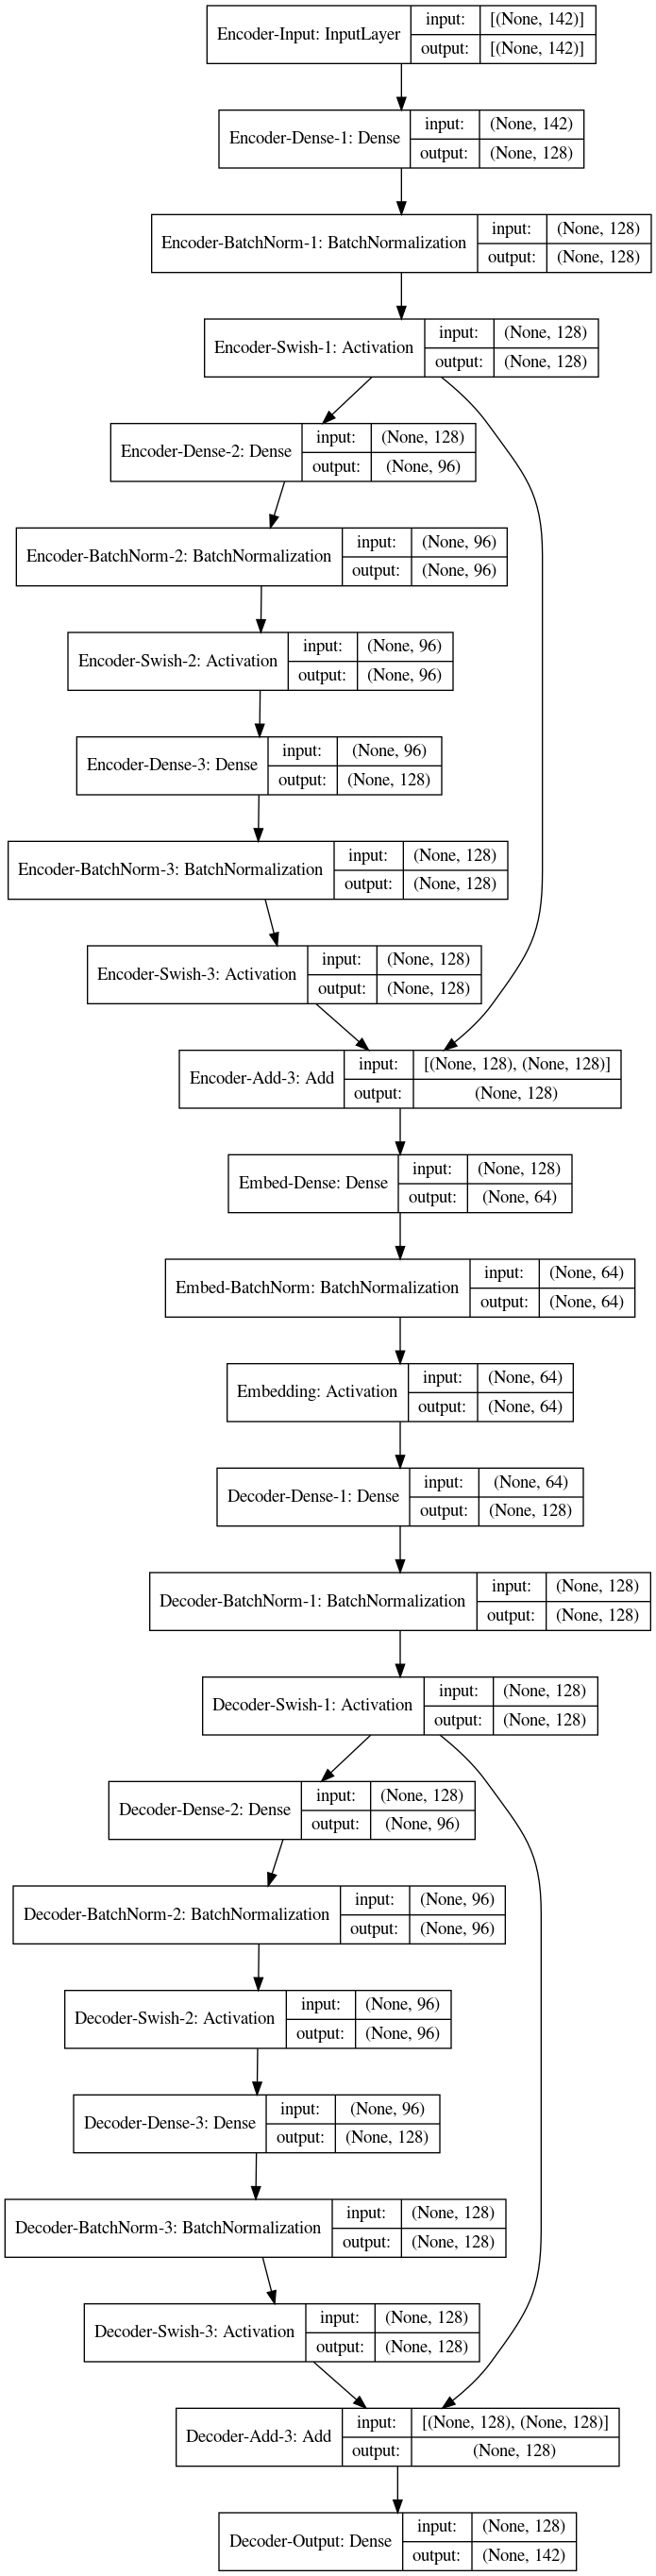

In [10]:
plot_model(
    model, to_file='./DAE_model.png', 
    show_shapes=True, show_layer_names=True
)

In [11]:
history = model.fit(
    Xtrain, 
    batch_size=mini_batch_size,
    epochs=150, 
    verbose=1, 
    workers=5,
    callbacks=[reduce_lr, early, chk_point], 
    validation_data=Xtest
)

Epoch 1/150
355/355 [==============================] - 17s 31ms/step - loss: 2.9284 - val_loss: 1.3840

Epoch 00001: val_loss improved from inf to 1.38400, saving model to ./DAE_model.h5
Epoch 2/150
355/355 [==============================] - 11s 31ms/step - loss: 1.1933 - val_loss: 0.8322

Epoch 00002: val_loss improved from 1.38400 to 0.83224, saving model to ./DAE_model.h5
Epoch 3/150
355/355 [==============================] - 11s 32ms/step - loss: 0.6876 - val_loss: 0.5771

Epoch 00003: val_loss improved from 0.83224 to 0.57709, saving model to ./DAE_model.h5
Epoch 4/150
355/355 [==============================] - 11s 32ms/step - loss: 0.4614 - val_loss: 0.4079

Epoch 00004: val_loss improved from 0.57709 to 0.40792, saving model to ./DAE_model.h5
Epoch 5/150
355/355 [==============================] - 12s 33ms/step - loss: 0.3493 - val_loss: 0.3232

Epoch 00005: val_loss improved from 0.40792 to 0.32321, saving model to ./DAE_model.h5
Epoch 6/150
355/355 [============================

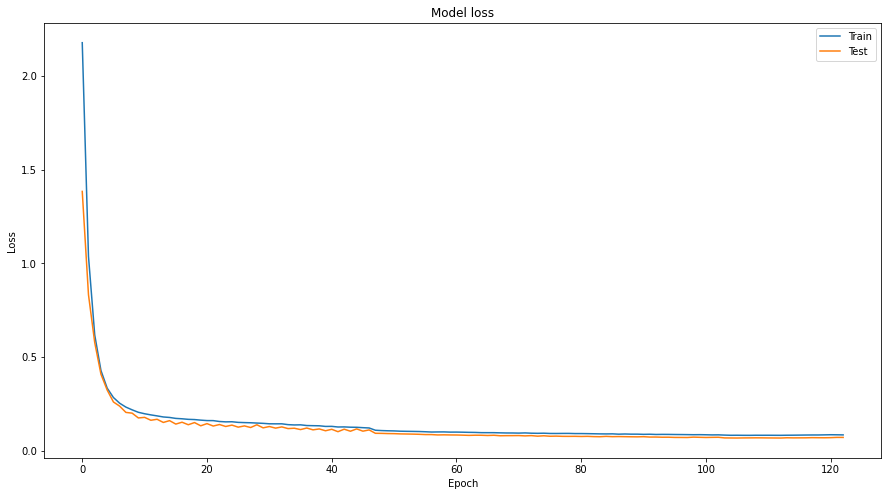

In [12]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Validate autoencoder output

In [13]:
model = load_model('./DAE_model.h5')
y_pred = model.predict(test_.values)
y_pred.shape

(11382, 142)

In [14]:
test_.head()

,age,gender,joined_through_referral,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,...,time_category_3.0,complaint_category_0.0,complaint_category_1.0,complaint_category_2.0,feedback_category_0.0,feedback_category_1.0,feedback_category_2.0,last_login_category_1,last_login_category_2,last_login_category_3
2346,-0.050204,1.0,1.0,-0.162552,0.450619,0.155709,1.301191,-0.517416,0.0,1.0,...,1,1,0,0,1,0,0,0,1,0
31735,0.366873,1.0,0.0,-1.786156,-0.446776,0.689707,0.523537,0.643775,0.0,1.0,...,0,0,0,1,1,0,0,1,0,0
50848,-1.926403,1.0,1.0,0.051460,-1.327982,-0.543192,-2.541191,0.415746,1.0,0.0,...,0,0,0,1,1,0,0,0,1,0
8431,1.384628,1.0,1.0,1.873053,-0.547935,1.288567,0.023839,-0.277850,1.0,0.0,...,0,0,1,0,1,0,0,0,0,1
35013,1.521525,1.0,1.0,-0.675277,0.287231,2.232713,-1.501861,1.812251,1.0,0.0,...,1,1,0,0,0,1,0,1,0,0


In [15]:
df = pd.DataFrame(y_pred, columns=test_.columns)
df.head()

,age,gender,joined_through_referral,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,...,time_category_3.0,complaint_category_0.0,complaint_category_1.0,complaint_category_2.0,feedback_category_0.0,feedback_category_1.0,feedback_category_2.0,last_login_category_1,last_login_category_2,last_login_category_3
0,-0.012853,0.914976,0.599409,-0.119540,0.577398,0.292185,1.346002,-0.485255,0.209927,0.961521,...,0.250558,0.975177,0.017373,0.006461,0.991495,0.003288,-0.009717,0.216588,0.820516,-0.046624
1,0.372596,0.926591,0.011292,-1.787378,-0.608042,0.657625,0.457825,0.676136,0.183899,0.899199,...,0.249583,0.102196,0.020775,0.898399,0.839004,0.136485,0.034443,1.108350,-0.101407,0.001503
2,-1.851218,1.036649,0.957850,0.154525,-1.294595,-0.491441,-2.534053,0.449196,0.999576,-0.022214,...,0.183069,0.063856,-0.014763,0.974335,0.875619,0.110170,0.004145,0.021722,1.087191,-0.082897
3,1.400933,0.895107,0.927216,1.976949,-0.608628,1.108982,-0.007437,-0.322921,0.957203,0.066578,...,0.233699,0.020543,0.960452,0.035279,0.961997,0.030256,0.035590,0.153807,0.087389,0.785640
4,1.598647,0.911013,0.895245,-0.763291,0.398134,2.224198,-1.432194,2.102394,1.091795,0.126933,...,0.263730,0.790959,0.064894,0.152654,-0.157849,1.242240,-0.076761,0.799422,0.273225,-0.046992


In [16]:
mse = (np.square(test_.values - df.values)).mean()
print("MSE: {}".format(mse))

MSE: 0.030816488777405598
